In [77]:
import numpy as np
import random
import pygame as pg

random.randrange(10,50)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


45

In [273]:
from scipy.spatial import distance
import enum 
import copy 

SENSE_FACTOR = 2

class Block:
    def __init__(self):
        self.content = None
    
    def set_content(self, content):
        self.content = content
        
class State(enum.Enum):
    FIND_FOOD = 0
    GO_BACK = 1

class Organism:
    color = (255, 255, 255)
    food_found = 0
    state = State.FIND_FOOD
    energy = 0
    
    def __init__(self, size, speed, sense, max_w, max_h):
        self.size = size
        self.speed = speed
        self.sense = sense
        
        self.max_w = max_w-1
        self.max_h = max_h-1
        
        # Organism starts at a border
        if random.random() > 0.5:
            self.x = random.uniform(0, max_w-1)
            self.y = 0
            if random.random() > 0.5:
                self.y = max_h-1
        else:
            self.y = random.uniform(0, max_h-1)
            self.x = 0
            if random.random() > 0.5:
                self.x = max_w-1
        
    def energy_cost(self):
        return ((self.size**3)*self.speed**2)+self.sense
    
    def get_coordinates(self):
        return (self.x, self.y)
    
    def reproduce(self, energy):
        offspring = copy.deepcopy(self)
        mutation_chance = 0.1
        
        offspring.size += (mutation_chance>random.random())*self.size *random.randrange(10,50)*0.01 * (2*(0.5>random.random())-1)
        offspring.speed += (mutation_chance>random.random())*self.speed*random.randrange(10,50)*0.01 * (2*(0.5>random.random())-1)
        offspring.sense += (mutation_chance>random.random())*self.sense*random.randrange(10,50)*0.01 * (2*(0.5>random.random())-1)
        offspring.energy = energy      
        offspring.state = State.FIND_FOOD
        
        return offspring
    
    def attributes(self):
        return np.array([self.size, self.speed, self.sense])
    
    def closest_border(self):
        borders = [[self.x, 0], [self.max_w, self.y], [self.x, self.max_h],[0, self.y]]
        distances = distance.cdist([self.get_coordinates()], borders, 'euclidean')[0]
        closest_idx = np.argmin(distances)
        
        return distances[closest_idx], borders[closest_idx][0], borders[closest_idx][1]
    
    def walk(self, env):
        distances = []
        a = 0
        b = 0
        
        if len(env["food"]) > 0:
            distances = distance.cdist([self.get_coordinates()], env["food"], 'euclidean')[0]
            closest_idx = np.argmin(distances)
        
        if self.state == State.GO_BACK:
            dist, x, y = self.closest_border()
            factor = min(self.speed, dist)/dist
            a = (x - self.x)*(1 if np.isnan(factor) else factor)
            b = (y - self.y)*(1 if np.isnan(factor) else factor)
        elif (len(distances) > 0) and (distances[closest_idx] <= (self.sense * SENSE_FACTOR)):
            factor = min(self.speed, distances[closest_idx])/distances[closest_idx]
            a = (env["food"][closest_idx][0] - self.x)*(1 if np.isnan(factor) else factor)
            b = (env["food"][closest_idx][1] - self.y)*(1 if np.isnan(factor) else factor)
            
        else:
            # a^2 + b^2 = c^2
            a2 = random.random() 
            b2 = 1-a2

            a = np.sqrt(a2) * (2*(0.5>random.random())-1)
            b = np.sqrt(b2) * (2*(0.5>random.random())-1)
        
        if self.energy >= self.energy_cost():
            self.x += a
            self.y += b
        
        self.energy -= self.energy_cost()   
    

In [5]:
w, h = 100, 100
env = np.zeros([w, h])
n_food = 6

for f in range(n_food):
    x, y = random.randrange(0,w), random.randrange(0,h)
    env[x][y] = 1
    
env.shape[0]

100

In [93]:
import numpy as np
import random
import pygame as pg


SCREEN_WIDTH, SCREEN_HEIGHT = 800,600
ENV_WIDTH, ENV_HEIGHT = 50, 40

BACK_COLOR = (100, 100, 100)
BLOCK_COLOR = (200, 200, 200)
MAZE_COLOR = (255, 255, 255)
UNVISITED_COLOR = (200, 200, 200)


BLOCK_SIZE = 10  # Pixel size/Wall thickness

ENV_WIDTH_PX = BLOCK_SIZE * ENV_WIDTH 
ENV_HEIGHT_PX = BLOCK_SIZE * ENV_HEIGHT 
ENV_TOP_LEFT_CORNER = (SCREEN_WIDTH // 2 - ENV_WIDTH_PX // 2, SCREEN_HEIGHT // 2 - ENV_HEIGHT_PX // 2)



pg.init()
screen = pg.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))

def init_env(w,h):
    return [[Block() for j in range(h)] for i in range(w)]

def init_organisms(n, attr):
    organisms = []
    for _ in range(n):
        o = Organism(attr[0], attr[1], attr[2], ENV_WIDTH, ENV_HEIGHT)
        organisms.append(o)
    return organisms


def draw(color, x, y):
    pg.draw.rect(screen, color, (x+1, y+1, BLOCK_SIZE-1, BLOCK_SIZE-1))

def draw_environment(screen, env):
        screen.fill(BACK_COLOR)
        pg.draw.rect(screen, MAZE_COLOR, (ENV_TOP_LEFT_CORNER[0], ENV_TOP_LEFT_CORNER[1],
                                               ENV_WIDTH_PX, ENV_HEIGHT_PX))

        for x in range(len(env)):
            for y in range(len(env[0])):
                draw_x = x*BLOCK_SIZE + ENV_TOP_LEFT_CORNER[0]
                draw_y = y*BLOCK_SIZE + ENV_TOP_LEFT_CORNER[1]
                
                color = BLOCK_COLOR
                
                c = env[x][y].content
                if isinstance(c, Organism):
                    color = c.color
                elif c == "food":
                    color = (0,255,0)
                elif c == "+":
                    color = (0,0,0)
                
                draw(color, draw_x, draw_y)

def kill_organisms(organisms, env):
    kill_counter = 0
    
    for o in organisms.copy():
        if (not (o.x == 0 or o.y == 0)) and (not (o.x == ENV_WIDTH-1 or o.y == ENV_HEIGHT-1)):
            organisms.remove(o)
            env[int(o.x)][int(o.y)].content = "+"
            kill_counter += 1
    #print("{} organisms killed".format(kill_counter))
            
            
def reproduce_organisms(organisms):
    babies = []
    for o in organisms:
        babies.append(o.reproduce())
    organisms.extend(babies)
    #print("{} babies born".format(len(babies)))
                
def do_one_step(organisms, env, n_food):
    max_attr = np.max(np.array([o.attributes() for o in organisms]))
    
    for o in organisms:
        x, y = o.get_coordinates()
        env[int(x)][int(y)].set_content(None)
        o.walk()
        x, y = o.get_coordinates()
        x = min(max(x,0),ENV_WIDTH-1)
        y = min(max(y,0), ENV_HEIGHT-1)
        o.x, o.y = x, y
        o.color = o.attributes()*255/max_attr
        env[int(x)][int(y)].set_content(o)
                
def run_simulation():
    pg.display.update()
    
    env = init_env(ENV_WIDTH, ENV_HEIGHT)
    n_food = 2
    for f in range(n_food):
        x, y = random.randrange(1,ENV_WIDTH-1), random.randrange(1,ENV_HEIGHT-1)
        env[x][y].set_content("food")
        
    organisms = init_organisms(20, (2, 2, 1))
    # Main game loop
    run = True
    
    time_keeper = {"day":0, "minute":0}
    stats = {"population":[len(organisms)], "attributes":[[o.attributes() for o in organisms]]}
    while run:
        for event in pg.event.get():
            if event.type == pg.QUIT:
                run = False
        
        if len(organisms) == 0:
            run = False
            continue
        
        # do one simulation step
        do_one_step(organisms, env, n_food)
        time_keeper["minute"] += 1
        if time_keeper["minute"] >= 100:#24*60:
            time_keeper["minute"] = 0
            time_keeper["day"] += 1
            kill_organisms(organisms, env)
            reproduce_organisms(organisms)
            for f in range(n_food):
                x, y = random.randrange(1,ENV_WIDTH-1), random.randrange(1,ENV_HEIGHT-1)
                env[x][y].set_content("food")
            pg.time.wait(500)
            
            stats["population"].append(len(organisms))
            stats["attributes"].append([o.attributes() for o in organisms])
        
        
        draw_environment(screen, env)
        pg.display.update()
        #pg.time.wait(500)
        pg.event.pump()

    pg.quit()
    return stats
    
stats = run_simulation()

In [ ]:
import numpy as np
import random
import pygame as pg


SCREEN_WIDTH, SCREEN_HEIGHT = 800,600
ENV_WIDTH, ENV_HEIGHT = 50, 40

BACK_COLOR = (100, 100, 100)
BLOCK_COLOR = (200, 200, 200)
MAZE_COLOR = (255, 255, 255)
UNVISITED_COLOR = (200, 200, 200)


BLOCK_SIZE = 10  # Pixel size/Wall thickness

ENV_WIDTH_PX = BLOCK_SIZE * ENV_WIDTH 
ENV_HEIGHT_PX = BLOCK_SIZE * ENV_HEIGHT 
ENV_TOP_LEFT_CORNER = (SCREEN_WIDTH // 2 - ENV_WIDTH_PX // 2, SCREEN_HEIGHT // 2 - ENV_HEIGHT_PX // 2)

MINUTES_PER_DAY = 100
DAY_ENERGY = 40*MINUTES_PER_DAY


pg.init()
screen = pg.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))

def init_organisms(n, attr):
    organisms = []
    for _ in range(n):
        o = Organism(attr[0], attr[1], attr[2], ENV_WIDTH, ENV_HEIGHT)
        o.energy = DAY_ENERGY
        organisms.append(o)
    return organisms


def draw(color, x, y):
    pg.draw.rect(screen, color, (x+1, y+1, BLOCK_SIZE-1, BLOCK_SIZE-1))

def draw_environment(screen, env):
        screen.fill(BACK_COLOR)
        pg.draw.rect(screen, (0,0,0), (ENV_TOP_LEFT_CORNER[0], ENV_TOP_LEFT_CORNER[1],
                                               ENV_WIDTH_PX, ENV_HEIGHT_PX))
        draw_x, draw_y, color = 0, 0, None
        for o in env["organisms"]:
            draw_x = o.x*BLOCK_SIZE + ENV_TOP_LEFT_CORNER[0]
            draw_y = o.y*BLOCK_SIZE + ENV_TOP_LEFT_CORNER[1]
            color = o.color
            draw(color, draw_x, draw_y)
        for xy in env["food"]:
            color = (0,255,0)
            draw_x = xy[0]*BLOCK_SIZE + ENV_TOP_LEFT_CORNER[0]
            draw_y = xy[1]*BLOCK_SIZE + ENV_TOP_LEFT_CORNER[1]
            draw(color, draw_x, draw_y)

def kill(env):
    kill_counter = 0
    
    for o in env["organisms"].copy():
        dist_to_border, _, _ = o.closest_border()
        if (o.energy <= 0) or (dist_to_border > 1):
            env["organisms"].remove(o)
            kill_counter += 1
    #print("{} organisms killed".format(kill_counter))
            
            
def sleep_and_reproduce(env):
    babies = []
    for o in env["organisms"]:
        if o.food_found >= 2:
            babies.append(o.reproduce(DAY_ENERGY))
        o.food_found = 0
        o.energy = DAY_ENERGY
        o.state = State.FIND_FOOD
    env["organisms"].extend(babies)
    #print("{} babies born".format(len(babies)))
                
def do_one_step(env, m):
    minutes_left = MINUTES_PER_DAY - m
    
    attributes = np.array([o.attributes() for o in env["organisms"]])
    max_attr = np.max(attributes)
    
    for o in env["organisms"]:
        x, y = o.get_coordinates()
        o.walk(env)
        if [o.x, o.y] in env["food"]:
            env["food"].remove([o.x, o.y])
            o.food_found += 1
            dist_to_border, _, _ = o.closest_border()
            if (o.food_found > 1) or (dist_to_border/o.speed >= minutes_left-5):
                o.state = State.GO_BACK
            
        x, y = o.get_coordinates()
        x %= (ENV_WIDTH-1)#min(max(x,0),ENV_WIDTH-1)
        y %= (ENV_HEIGHT-1)#min(max(y,0), ENV_HEIGHT-1)
        o.x, o.y = x, y
        o.color = o.attributes()*255/max_attr
                
def run_simulation():
    pg.display.update()
    
    env = {"food" : [], "organisms" : []}
    n_food = 10
    for f in range(n_food):
        x, y = random.randrange(1,ENV_WIDTH-1), random.randrange(1,ENV_HEIGHT-1)
        env["food"].append([x, y])
        
    organisms = init_organisms(1, (2, 0.5, 1))
    env["organisms"].extend(organisms)
    # Main game loop
    run = True
    
    time_keeper = {"day":0, "minute":0}
    stats = {"population":[len(organisms)], "attributes":[[o.attributes() for o in organisms]]}
    while run:
        for event in pg.event.get():
            if event.type == pg.QUIT:
                run = False
        
        if len(env["organisms"]) == 0:
            run = False
            continue
        
        # do one simulation step
        do_one_step(env, time_keeper["minute"])
        time_keeper["minute"] += 1
        if time_keeper["minute"] >= 100:#24*60:
            time_keeper["minute"] = 0
            time_keeper["day"] += 1
            kill(env)
            sleep_and_reproduce(env)
            for f in range(n_food):
                x, y = random.randrange(1,ENV_WIDTH-1), random.randrange(1,ENV_HEIGHT-1)
                env["food"].append([x, y])
            pg.time.wait(500)
            
            attributes = np.array([o.attributes() for o in env["organisms"]])
            
            stats["population"].append(len(env["organisms"]))
            stats["attributes"].append(attributes)
        
        
        draw_environment(screen, env)
        pg.display.update()
        pg.time.wait(10)
        pg.event.pump()

    pg.quit()
    return stats
    
stats = run_simulation()

c:\users\hayoo\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in double_scalars
c:\users\hayoo\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in double_scalars


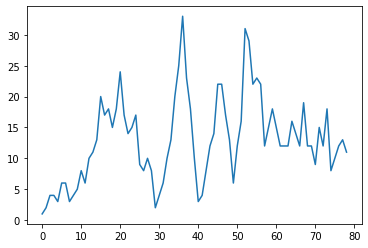

[[ 1.14        1.9702116   7.643532  ]
 [ 1.14        1.9702116   7.643532  ]
 [ 1.14        1.57616928  9.40154435]
 [ 1.14        1.9702116  11.00668607]
 [ 1.14        1.87564144  9.40154435]
 [ 1.14        1.9702116   7.643532  ]
 [ 1.14        1.9702116   7.643532  ]
 [ 1.14        2.87650894  7.643532  ]
 [ 1.14        1.57616928  9.40154435]
 [ 0.9462      1.9702116  11.00668607]
 [ 1.14        1.87564144  9.40154435]
 [ 1.14        1.9702116   7.643532  ]]


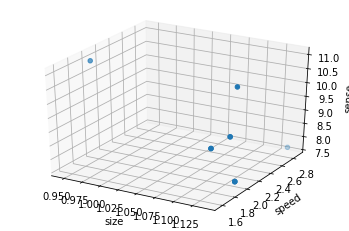

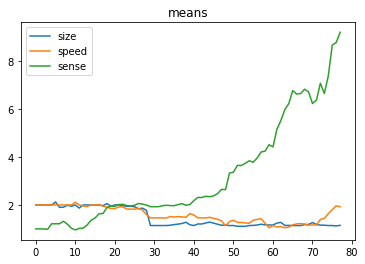

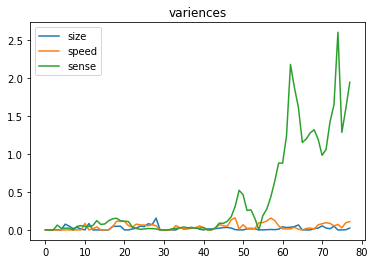

In [275]:
%matplotlib inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # for 3D plotting

fig = plt.figure()
plt.plot(np.arange(0,len(stats["population"])), stats["population"])
plt.show()

atts = np.array(stats["attributes"][len(stats["attributes"])-3])
print(atts)
si = atts[:,0] 
sp = atts[:,1]
se = atts[:,2]
fig2 = plt.figure()
ax = fig2.gca(projection='3d')
ax.scatter(xs=si,ys=sp,zs=se)
ax.set_xlabel("size")
ax.set_ylabel("speed")
ax.set_zlabel("sense")
plt.show()


means = np.array([[np.mean(atts[:,0]), np.mean(atts[:,1]), np.mean(atts[:,2])] if len(atts) > 1 else atts[0] for atts in stats["attributes"][:-1]])
variances =  np.array([[np.var(atts[:,0]),  np.var(atts[:,1]),  np.var(atts[:,2])] if len(atts) > 1 else [0, 0, 0] for atts in stats["attributes"][:-1]])

fig = plt.figure()
plt.plot(np.arange(0,len(means)), means[:,0])
plt.plot(np.arange(0,len(means)), means[:,1])
plt.plot(np.arange(0,len(means)), means[:,2])
plt.legend(["size", "speed", "sense"])
plt.title("means")
plt.show()

fig = plt.figure()
plt.plot(np.arange(0,len(variances)), variances[:,0])
plt.plot(np.arange(0,len(variances)), variances[:,1])
plt.plot(np.arange(0,len(variances)), variances[:,2])
plt.legend(["size", "speed", "sense"])
plt.title("variences")
plt.show()